# Computational Intelligence for Optimization
## Project 2025 – Wedding Seating Optimization

### Group Members - Group P
Joana Esteves | 20240746 <br>
Matilde Miguel | 20240549 <br>
Tomás Figueiredo | 20240941 <br>
Rita Serra | 20240515 <br>

**Table of Contents**
- [1. Imports](#imports)
- [2. Grid Search](#gd)
- [3. Analysis of Configurations](#analysisconf)
    - [3.1. Performance of Selection Methods, Operators and Elitism](#perfoperat)
    - [3.2. Performance of each configuration](#perfconf)
    - [3.3. Performance of Top 5 Configurations](#perfconftop)
- [4. Grid search for optimization - tournment size and number of elits](#gd2)
    - [4.1. Performance analysis](#perfanalysis2)

<a class="anchor" id="imports">

# 1. Imports

</a>

In [1]:
# General imports
import pandas as pd
import numpy as np
from functools import partial

# Grid search
from library.genetic_algorithms.grid_search_parallelized import grid_search_par
from library.genetic_algorithms.mutation import swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation
from library.genetic_algorithms.crossover import cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover
from library.genetic_algorithms.selection import fitness_proportionate_selection, ranking_selection, tournament_selection

# Visualizations
import seaborn as sns
from matplotlib import pyplot as plt
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
import plotly.graph_objects as go
from IPython.display import display


In [2]:
# Load dataset
seating_data= pd.read_csv("seating_data.csv", index_col=0)

In [3]:
relationships_mtx=seating_data.to_numpy()

In [4]:
relationships_mtx

array([[   0, 5000,    0, ...,    0,    0,    0],
       [5000,    0,  700, ...,    0,    0,    0],
       [   0,  700,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,  700,  700],
       [   0,    0,    0, ...,  700,    0,  900],
       [   0,    0,    0, ...,  700,  900,    0]])

<a class="anchor" id="gd">

# 2. Grid Search

</a>

**Fixed hyperparameters:**
- Population size = 100.
- Max generations = 100 - termination condition.
- Crossover probability = 0.9.
- Mutation probability = 0.1.
- When selection method is tournment: tournment size = 5.

**Hyperparameters to test:**
- Selection methods.
- Crossover operators.
- Mutation operators.
- Elitism.

In [ ]:
# Define grid search combinations
# Run parallelized grid search

results = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[swap_mutation, inversion_mutation, heuristic_mutation, misfit_mutation],
    crossover_functions=[cycle_crossover, one_point_crossover, uniform_crossover, geometric_crossover],
    selection_functions=[fitness_proportionate_selection, ranking_selection, tournament_selection],
    elitism=[0,1]
)

results

[{'mutation': 'heuristic_mutation',
  'crossover': 'geometric_crossover',
  'selection': 'tournament_selection',
  'elitism': 1,
  'last_gen_avg_fitness': np.float64(78346.66666666667),
  'solution_highest_fitness': <library.SA_problem.seating_arrangement.SASolution at 0x20341fb3440>,
  'execution_time': 21.119258880615234}]

In [ ]:
# Present combination which reached highest fitness in the last generation 

results_table1 = pd.DataFrame(results).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table1

,mutation,crossover,selection,elitism,last_gen_avg_fitness,solution_highest_fitness,execution_time
0,heuristic_mutation,geometric_crossover,tournament_selection,1,78346.667,"Table 0: [28, 29, 30, 31, 32, 33, 34, 35] Table 1: [36, 37, 39, 40, 41, 42, 43, 49] Table 2: [46, 47, 58, 59, 60, 61, 62, 63] Table 3: [22, 23, 24, 25, 26, 27, 45, 48] Table 4: [50, 51, 52, 53, 54, 55, 56, 57] Table 5: [10, 11, 12, 13, 14, 21, 38, 44] Table 6: [4, 5, 15, 16, 17, 18, 19, 20] Table 7: [0, 1, 2, 3, 6, 7, 8, 9]",21.119


<a class="anchor" id="analysisconf">

# 3. Analysis of Configurations

</a>

In [5]:
def print_mean_std_per_combination(fitness_per_run: pd.DataFrame):
    '''
    Prints the top 10 hyperparameter combinations with the highest mean standard deviation 
    of fitness across different runs, providing insight into variability of performance.

    Parameters:
    fitness_per_run (pd.DataFrame): DataFrame with the fitness of different configurations of the genetic algorithm 
                                    across several runs.

    '''

    stats = fitness_per_run.groupby(
        ["mutation", "crossover", "selection", "elitism", "generation"]
    )["fitness"].std().reset_index(name="std_fitness")

    stats["combination"] = stats.apply(
        lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
        axis=1
    )
    mean_std_per_comb = stats.groupby("combination")["std_fitness"].mean().reset_index(name="mean_std")

    mean_std_per_comb = mean_std_per_comb.sort_values(by="mean_std", ascending=False).head(10)

    print("\nTop 10 combinations - mean of std across generations:")
    for _, row in mean_std_per_comb.iterrows():
        print(f"{row['combination']}: mean std = {row['mean_std']:.4f}")

    return


In [6]:
# Load fitness per run for all combinations
fitness_per_run = pd.read_csv("fitness_per_run.csv")

In [230]:
# Print mean std across generation for top 10 combinations
print_mean_std_per_combination(fitness_per_run)


Top 10 combinations - mean of std across generations:
misfit_mutation, uniform_crossover, tournament_selection, E1: mean std = 6436.5610
misfit_mutation, uniform_crossover, tournament_selection, E0: mean std = 5027.7982
misfit_mutation, one_point_crossover, tournament_selection, E0: mean std = 4806.8883
misfit_mutation, cycle_crossover, tournament_selection, E0: mean std = 4214.0236
misfit_mutation, one_point_crossover, ranking_selection, E0: mean std = 4159.2227
misfit_mutation, cycle_crossover, tournament_selection, E1: mean std = 4002.3072
inversion_mutation, uniform_crossover, tournament_selection, E1: mean std = 3985.0879
misfit_mutation, geometric_crossover, tournament_selection, E0: mean std = 3932.1727
misfit_mutation, one_point_crossover, ranking_selection, E1: mean std = 3924.7472
swap_mutation, uniform_crossover, fitness_proportionate_selection, E1: mean std = 3897.0810


**Create csv with median fitness per generation**
- Given that the algorithms' performances vary highly across runs, we decided to use the median instead of the mean, therefor a new csv file will be created to perform analysis using the median. 

In [ ]:
def csv_median_fitness_per_gen(fitness_per_run: pd.DataFrame, timestamp: str = None) -> pd.DataFrame:
    '''
    Calculates the median fitness per generation for each hyperparameter combination 
    and saves the results to a CSV file.

    Parameters:
    fitness_per_run (pd.DataFrame): DataFrame with the fitness of different configurations of the genetic algorithm 
                                    across several runs.
    timestamp (str, optional): String to be used in the filename to distinguish different files.
    '''
    median_fit_per_gen = fitness_per_run.groupby(
    ["mutation", "crossover", "selection", "elitism", "generation"]
    )["fitness"].median().reset_index(name="median_fitness")

    filename = f"median_fit_per_generation_{timestamp}.csv" if timestamp else "median_fit_per_generation.csv"
    median_fit_per_gen.to_csv(filename, index=False)

    return

In [244]:
# Create csv with median 
csv_median_fitness_per_gen(fitness_per_run)

In [7]:
# Load median fitness per generation for all combinations
median_fit_per_gen= pd.read_csv("median_fit_per_generation.csv")

In [7]:
print(fitness_per_run.shape)
print(median_fit_per_gen.shape)

(288000, 7)
(9600, 6)


In [296]:
fitness_per_run.head()

,run,mutation,crossover,selection,elitism,generation,fitness
0,1,swap_mutation,cycle_crossover,fitness_proportionate_selection,0,1,22400
1,1,swap_mutation,cycle_crossover,fitness_proportionate_selection,0,2,22900
2,1,swap_mutation,cycle_crossover,fitness_proportionate_selection,0,3,22400
3,1,swap_mutation,cycle_crossover,fitness_proportionate_selection,0,4,22800
4,1,swap_mutation,cycle_crossover,fitness_proportionate_selection,0,5,24900


In [297]:
median_fit_per_gen.head()

,mutation,crossover,selection,elitism,generation,median_fitness
0,heuristic_mutation,cycle_crossover,fitness_proportionate_selection,0,1,24500.0
1,heuristic_mutation,cycle_crossover,fitness_proportionate_selection,0,2,24800.0
2,heuristic_mutation,cycle_crossover,fitness_proportionate_selection,0,3,25600.0
3,heuristic_mutation,cycle_crossover,fitness_proportionate_selection,0,4,26750.0
4,heuristic_mutation,cycle_crossover,fitness_proportionate_selection,0,5,27000.0


<a class="anchor" id="perfoperat">

## 3.1. Performance of Selection Methods, Operators and Elitism

</a>

In [8]:
def plot_median_fitness_by_parameter(median_fit_per_gen: pd.DataFrame, parameter: str):
    '''
    Plots the median fitness for each generation across runs and medium performance across configurations, 
    grouped by the specified hyperparameter.

    Parameters:
    median_fit_per_gen (pd.DataFrame): DataFrame containing median fitness per generation across runs and for 
                                       different configurations of the genetic algorithm.

    parameter (str): Name of the hyperparameter to group by.
    '''

    grouped = median_fit_per_gen.groupby([parameter, "generation"])["median_fitness"].median().reset_index()

    plt.figure(figsize=(10, 5))
    for op in grouped[parameter].unique():
        subset = grouped[grouped[parameter] == op]
        plt.plot(subset["generation"], subset["median_fitness"], label=op)

    plt.title(f"Median Fitness per Generation by {parameter.capitalize()}")
    plt.xlabel("Generation")
    plt.ylabel("Median Fitness")
    plt.legend(title=parameter.capitalize(), loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

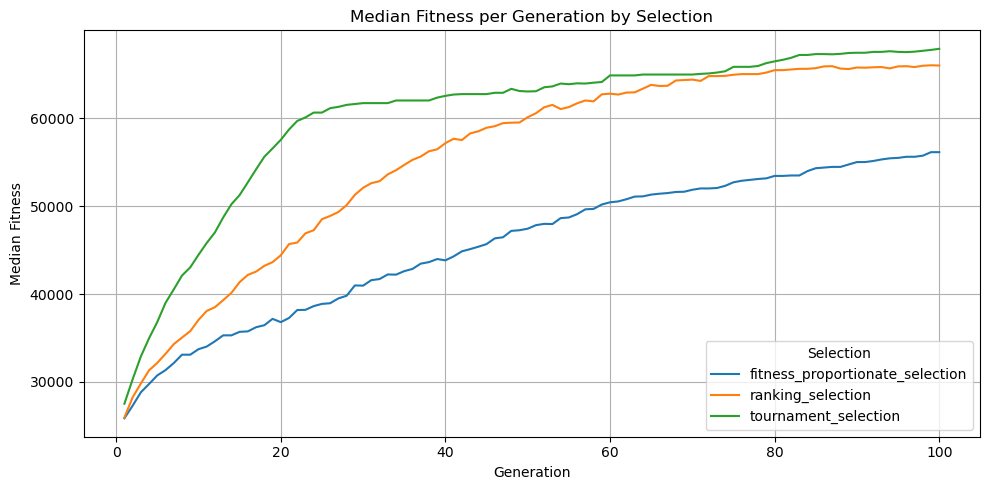

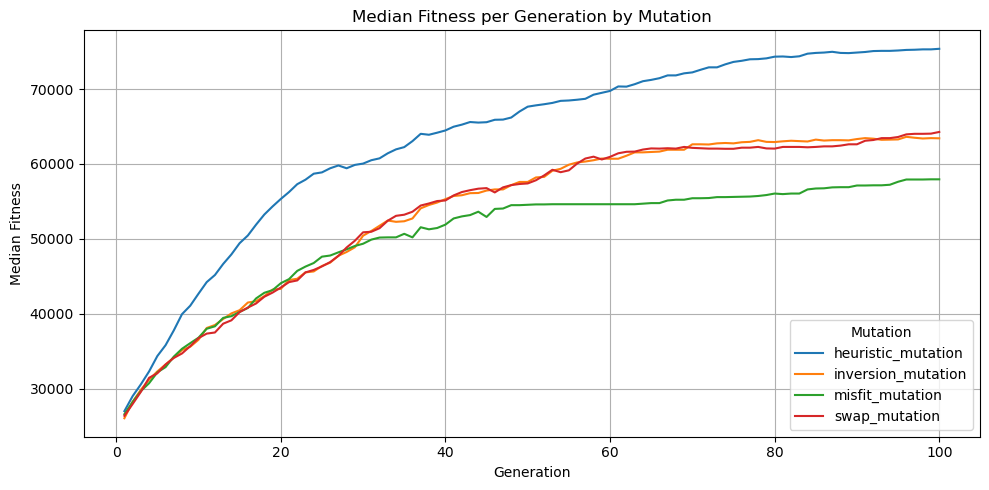

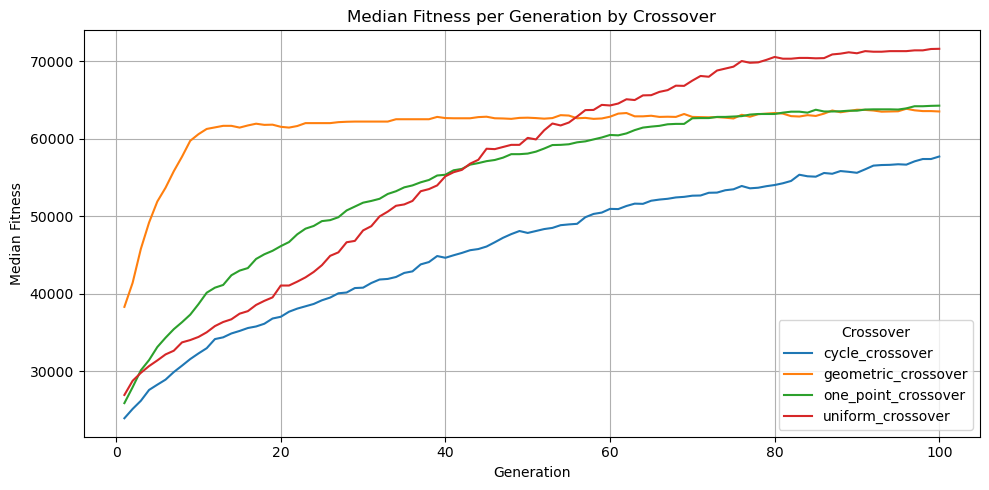

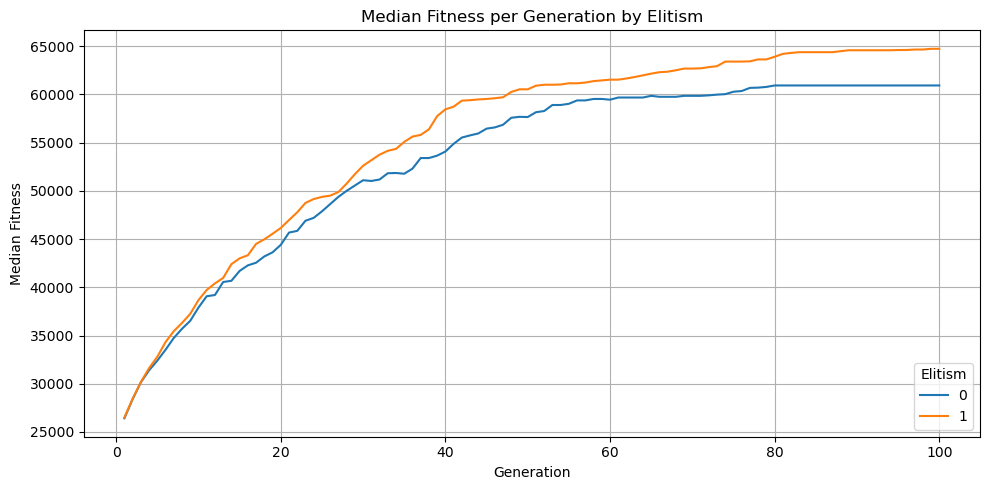

In [309]:
# Plot fitness history for each selection, operators and elitism

parameters = ["selection", "mutation", "crossover", "elitism"]

for par in parameters: 
    plot_median_fitness_by_parameter(median_fit_per_gen, par)


<a class="anchor" id="perfconf">

## 3.2. Performance of each configuration 

</a>

**Fitness history:**

In [8]:
def plot_median_fitness_per_gen(fitness_per_run: pd.DataFrame):
    '''
    Plots the evolution of the median fitness for each gen across runs for each hyperparameter combination,
    including interquartile range (IQR) shading to represent variability.

    Parameters:
    fitness_per_run (pd.DataFrame): DataFrame with the fitness of different configurations of the genetic algorithm 
                                    across several runs.
    '''

    # Calculate stats and combinations
    stats = fitness_per_run.groupby(
        ["mutation", "crossover", "selection", "elitism", "generation"]
    )["fitness"].agg(
        median_fitness="median",
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    ).reset_index()

    # Create columns "combination" for stats 
    stats["combination"] = stats.apply(
        lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
        axis=1
    )

    # Plot for each combination 
    plt.figure(figsize=(10, 8))
    for combo in stats["combination"].unique():
        subset = stats[stats["combination"] == combo]
        plt.plot(subset["generation"], subset["median_fitness"], label=combo, alpha=0.6)
        plt.fill_between(subset["generation"], subset["q1"], subset["q3"], alpha=0.1)

    plt.xlabel("Generation")
    plt.ylabel("Median Fitness")
    plt.title("Median Fitness Evolution with IQR")
    plt.grid(True)

    plt.legend(
        bbox_to_anchor=(0.5, -0.2),
        loc='upper center',
        fontsize="small",
        ncol=2,
        title="Combinations",
        title_fontsize="medium"
    )

    plt.tight_layout(rect=[0, 0.05, 0.8, 0.8]) 
    plt.show()


/var/folders/fl/gygf4vxd5dz_9chtfs_f8n000000gn/T/ipykernel_5448/2464207222.py:39: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



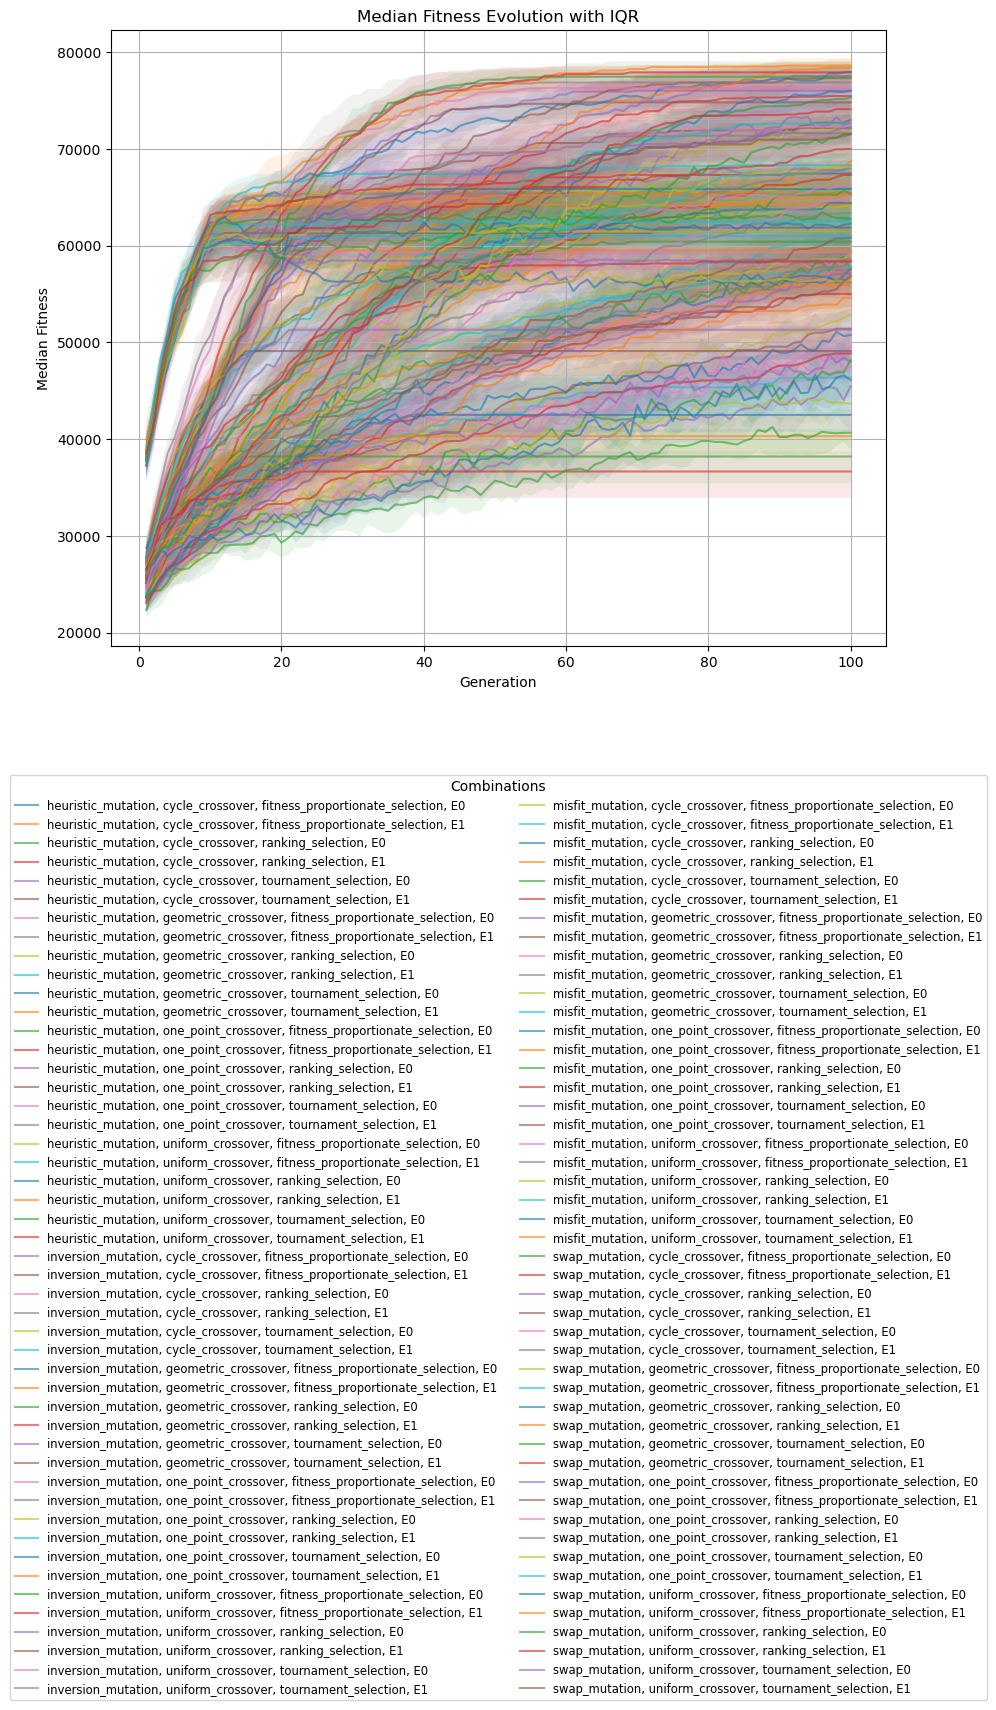

In [256]:
plot_median_fitness_per_gen(fitness_per_run)

Due to the high number of combinations being evaluated, we will focus on plotting only the top 5 combinations later in the notebook. These top 5 are selected based on achieving the highest median fitness values in the final generation. By doing so, we can clearly visualize and compare the best-performing configurations in terms of fitness evolution over the generations.

**Statistical analysis**
- Friedman test for significant differences.
- Post-hoc Nemenyi to analyze significant differences pair-wise.
- Boxplots and statistics summary - median, quartiles, interquartile distance - to analyze stability of results.

In [9]:
# abreviations for the operators (for better visualization)

def abbreviate_config(config):
    '''
    Converts a configuration string with full hyperparameter names into a abbreviation format.

    Parameters:
    config (str): String containing a comma-separated list of hyperparameter settings 

    Returns:
    str:  Abbreviated version of the configuration name (e.g., "HM-UC-TS-E1").
    '''
    parts = [part.strip() for part in config.split(',')]

    abbr = {
    'heuristic_mutation': 'HM',
    'swap_mutation': 'SM',
    'inversion_mutation': 'IM',
    'misfit_mutation': 'MM',
    'geometric_crossover': 'GC',
    'uniform_crossover': 'UC',
    'one_point_crossover': 'OPC',
    'cycle_crossover': 'CC',
    'tournament_selection': 'TS',
    'ranking_selection': 'RS',
    'fitness_proportionate_selection': 'FPS',
    }
    
    return '-'.join(abbr.get(part, part) for part in parts)

In [10]:
def test_significant_diffs(comb_last_gen_fitness_per_run: pd.DataFrame, top_n: int):
    '''
    Performs statistical testing to identify significant differences in fitness among 
    different hyperparameter configurations using the Friedman test followed by a post-hoc 
    Nemenyi test. Displays a significance table and a heatmap for the top configurations.

    Parameters:
    comb_last_gen_fitness_per_run (pd.DataFrame): 
        DataFrame where each column corresponds to a hyperparameter configuration and each
        row represents the fitness score of that configuration in the final generation of a run.

    top_n (int): 
        Number of top configurations (by mean rank) to display in the post-hoc heatmap.

    '''

    # Global significance test 
    stat, p = friedmanchisquare(*[comb_last_gen_fitness_per_run[col] for col in comb_last_gen_fitness_per_run.columns])
    print(f"Friedman test statistic: {stat:.4f}, p-value: {p:.4f}")

    alpha_sig = 0.05
    if p < alpha_sig:
        print("There are statistically significant differences between the configurations.")

        # Pair-wise test
        nemenyi = sp.posthoc_nemenyi_friedman(comb_last_gen_fitness_per_run.to_numpy())
        display(
            nemenyi.style
                .set_caption("Post-hoc Nemenyi test")
                .format(precision=4)
                .map(lambda v: 'background-color: lightcoral' if v < alpha_sig else '')
                .set_properties(**{'text-align': 'center'})
        )

        # Heatmap of posthoc results for best 10

        mean_ranks = comb_last_gen_fitness_per_run.rank(axis=1, method='average', ascending=False).mean().sort_values()

        top_configs = mean_ranks.head(top_n).index

        top_score_df = comb_last_gen_fitness_per_run[top_configs]
        nemenyi_top = sp.posthoc_nemenyi_friedman(top_score_df.to_numpy())
        nemenyi_top.index = nemenyi_top.columns = top_score_df.columns

        # Abreviar nomes
        abbr_labels = [abbreviate_config(config) for config in top_score_df.columns]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            nemenyi_top,
            annot=True,
            fmt=".3f",
            cmap="coolwarm",
            cbar_kws={"label": "p-value"},
            linewidths=0.5,
            linecolor='gray',
            mask=np.triu(np.ones_like(nemenyi_top, dtype=bool)),
            square=True
        )
        plt.title(f"Post-hoc Nemenyi Test (Top {top_n} Configurations by Mean Rank)", fontsize=14)
        plt.xticks(ticks=np.arange(len(abbr_labels)) + 0.5, labels=abbr_labels, rotation=90)
        plt.yticks(ticks=np.arange(len(abbr_labels)) + 0.5, labels=abbr_labels, rotation=0)
        plt.tight_layout()
        plt.show()

    else:
        print("No statistically significant differences were found between the configurations.")

    return
    

In [20]:
def combs_boxplots_per_selection(comb_last_gen_fitness_per_run: pd.DataFrame):
    '''
    Displays boxplots of fitness values across runs for the last generation grouped by 
    hyperparameter configurations and separated by selection method for readability.

    Parameters:
    comb_last_gen_fitness_per_run (pd.DataFrame): 
        DataFrame where each column corresponds to a hyperparameter configuration and each
        row represents the fitness score of that configuration in the final generation of a run.
    '''

    df_long = comb_last_gen_fitness_per_run.melt(var_name="Configuration", value_name="Fitness")

    df_long['Selection'] = df_long['Configuration'].apply(lambda x: x.split(',')[2])
    df_long['Config_Abbr'] = df_long['Configuration'].apply(abbreviate_config)

    stats_df = df_long.groupby("Configuration")["Fitness"].agg(
        min_score="min",
        q1_score=lambda x: np.percentile(x, 25),
        median_score="median",
        q3_score=lambda x: np.percentile(x, 75),
        max_score="max"
    ).reset_index()

    def make_hover(config):
        stats = stats_df[stats_df['Configuration'] == config].iloc[0]
        return (
            f"Max: {stats.max_score:.2f}<br>"
            f"Q3: {stats.q3_score:.2f}<br>"
            f"Median: {stats.median_score:.2f}<br>"
            f"Q1: {stats.q1_score:.2f}<br>"
            f"Min: {stats.min_score:.2f}"
        )

    df_long['hover'] = df_long['Configuration'].map(make_hover)

    selection_types = df_long['Selection'].unique()
    for sel_type in selection_types:
        df_sel = df_long[df_long['Selection'] == sel_type]

        fig = go.Figure()
        fig.add_trace(go.Box(
            x=df_sel['Config_Abbr'],
            y=df_sel['Fitness'],
            text=df_sel['hover'],
            hoverinfo='text',
            fillcolor='rgba(108, 140, 200, 0.3)',
            line=dict(color='rgba(108, 140, 200, 1)'),
            boxpoints='all',
            jitter=0,
            pointpos=0,
            marker=dict(color='rgba(108, 140, 200, 1)')
        ))

        fig.update_yaxes(title="Fitness", range=[0, df_long["Fitness"].max() * 1.05])
        fig.update_layout(
            title=f"Fitness per Configuration ({sel_type})",
            xaxis_title="Configuration",
            width=1000,
            height=600,
            plot_bgcolor='#f1f1f1',
            xaxis_tickfont=dict(size=10),
            xaxis_tickangle=-90,
            margin=dict(l=50, r=50, t=50, b=150),
            showlegend=False
        )
        fig.show()

    return

In [16]:
def combs_summary_stats(comb_last_gen_fitness_per_run: pd.DataFrame):
    '''
    Computes summary statistics (min, first quartile, median, third quartile, max, and IQR) 
    of fitness scores of last generation across runs, for each hyperparameter configuration.

    Parameters:
    comb_last_gen_fitness_per_run (pd.DataFrame): 
        DataFrame where each column corresponds to a hyperparameter configuration and each
        row represents the fitness score of that configuration in the final generation of a run.

    Returns:
    (pd.DataFrame): DataFrame with summary statistics per configuration, sorted by median fitness score.
    '''

    summary_stats = pd.DataFrame({
    "min_score": comb_last_gen_fitness_per_run.min(),
    "q1_score": comb_last_gen_fitness_per_run.quantile(0.25),
    "median_score": comb_last_gen_fitness_per_run.median(),
    "q3_score": comb_last_gen_fitness_per_run.quantile(0.75),
    "max_score": comb_last_gen_fitness_per_run.max(),
    })

    # Calculate IQR
    summary_stats["iqr_score"] = summary_stats["q3_score"] - summary_stats["q1_score"]

    summary_stats = summary_stats.reset_index().rename(columns={"index": "configuration"})

    # Order by median
    summary_stats = summary_stats.sort_values(by="median_score", ascending=False)

    print("Fitness Summary per Configuration:")
    display(summary_stats.round(2))

    return summary_stats

In [12]:
# For each combination get last generation fitness acrosso 30 runs 

last_gen = fitness_per_run[fitness_per_run["generation"] == 100].copy()

last_gen["configuration"] = last_gen.apply(
    lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
    axis=1
)

grouped = last_gen.groupby("configuration")["fitness"].apply(list)

comb_last_gen_fitness_per_run = pd.DataFrame(grouped.tolist(), index=grouped.index).T

Friedman test statistic: 2542.9379, p-value: 0.0000
There are statistically significant differences between the configurations.


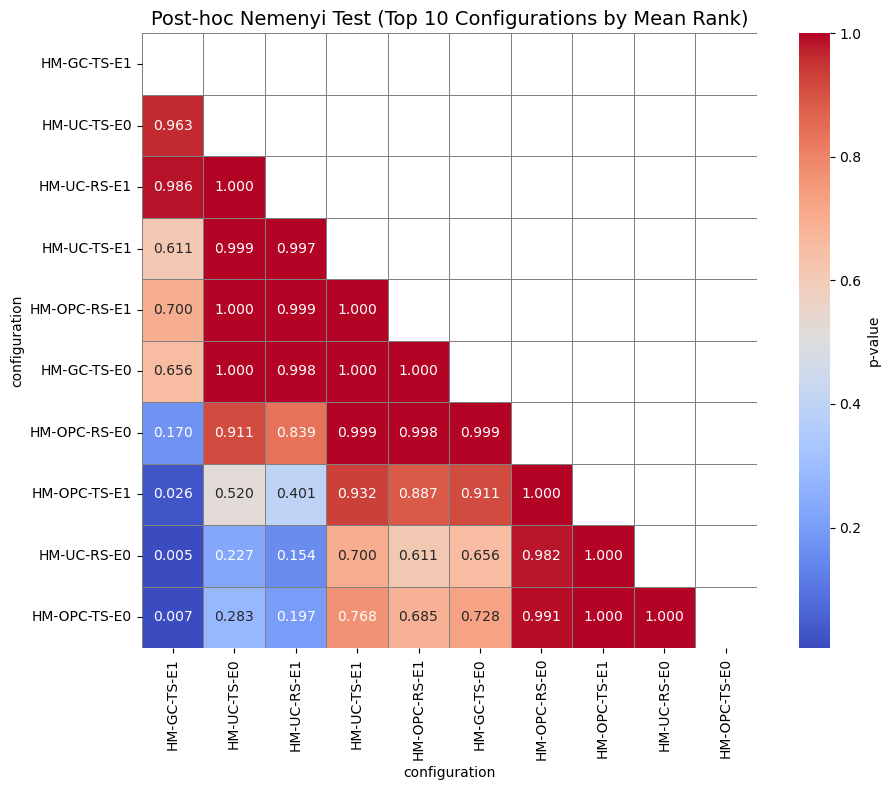

In [13]:
# Perform statistical tests for significance of differences between configurations
test_significant_diffs(comb_last_gen_fitness_per_run, 10)

In [ ]:
# Boxplots for each configuration grouped by selection method for readability 
combs_boxplots_per_selection(comb_last_gen_fitness_per_run)


In [17]:
# Compute summary statistics to analyze stability of performance
summary_stats = combs_summary_stats(comb_last_gen_fitness_per_run)

Fitness Summary per Configuration:


,configuration,min_score,q1_score,median_score,q3_score,max_score,iqr_score
11,"heuristic_mutation, geometric_crossover, tourn...",74200,77950.0,78600.0,79375.0,80300,1425.0
21,"heuristic_mutation, uniform_crossover, ranking...",69100,76550.0,78350.0,79300.0,81400,2750.0
10,"heuristic_mutation, geometric_crossover, tourn...",71200,76825.0,77950.0,78775.0,80000,1950.0
23,"heuristic_mutation, uniform_crossover, tournam...",73300,75975.0,77900.0,78650.0,80400,2675.0
14,"heuristic_mutation, one_point_crossover, ranki...",70900,76125.0,77600.0,78550.0,79800,2425.0
...,...,...,...,...,...,...,...
50,"misfit_mutation, cycle_crossover, ranking_sele...",36600,40725.0,42500.0,46375.0,60200,5650.0
72,"swap_mutation, cycle_crossover, fitness_propor...",36800,38950.0,40650.0,43075.0,51700,4125.0
51,"misfit_mutation, cycle_crossover, ranking_sele...",30800,38550.0,40300.0,42650.0,50000,4100.0
52,"misfit_mutation, cycle_crossover, tournament_s...",30100,35425.0,38200.0,41025.0,50000,5600.0


<a class="anchor" id="perfconftop">

## 3.3. Performance of Top 5 Configurations

</a>

We selected the top 5 configurations by the median performance in the last generation across 30 runs, to reduce the comparison scope and have cleaner visualizations. In this way, we will be able to select a final configuration more efficiently.

**Statistical analysis**
- Friedman test for significant differences.
- Post-hoc Nemenyi to analyze significant differences pair-wise.
- Boxplots and statistics summary - median, quartiles, interquartile distance - to analyze stability of results.

In [21]:
def combs_boxplots_top5(comb_last_gen_fitness_per_run: pd.DataFrame, summary_stats: pd.DataFrame, top5: list):
    '''
    Displays a boxplot for the top 5 configurations based on fitness scores of the last generation 
    across different runs.

    Parameters:
    comb_last_gen_fitness_per_run (pd.DataFrame):
        DataFrame where each column corresponds to a hyperparameter configuration and each
        row represents the fitness score of that configuration in the final generation of a run.

    summary_stats (pd.DataFrame):
        DataFrame with summary statistics (min, max, quartiles, median) of the fitness of last generation
        across runs, for each configuration.

    top5 (list):
        List of the names of the top 5 configurations.
    '''

    df_long = comb_last_gen_fitness_per_run.melt(var_name="configuration", value_name="Fitness")

    def make_hover(config):
        stats = summary_stats[summary_stats['configuration'] == config].iloc[0]
        return (
            f"Max: {stats.max_score:.2f}<br>"
            f"Q3: {stats.q3_score:.2f}<br>"
            f"Median: {stats.median_score:.2f}<br>"
            f"Q1: {stats.q1_score:.2f}<br>"
            f"Min: {stats.min_score:.2f}"
        )

    df_long['hover'] = df_long['configuration'].map(make_hover)

    df_top = df_long[df_long['configuration'].isin(top5)].copy()
    df_top['Config_Abbr'] = df_top['configuration'].apply(abbreviate_config)

    fig = go.Figure()
    fig.add_trace(go.Box(
        x=df_top['Config_Abbr'],
        y=df_top['Fitness'],
        text=df_top['hover'],
        hoverinfo='text',
        boxpoints='all',
        jitter=0,
        pointpos=0,
        marker=dict(color='rgba(108, 140, 200, 1)')
    ))

    fig.update_layout(
        title="Top 5 Configurations by Fitness (Generation 100)",
        xaxis_title="Configuration",
        yaxis_title="Fitness",
        width=1000,
        height=600,
        xaxis_tickangle=-45
    )
    fig.show()

In [18]:
# Get top 5 configurations by last generation median fitness across runs
top_configs = summary_stats.sort_values("median_score", ascending=False).head(5)
top_5_names = top_configs['configuration'].tolist()

**Fitness history:**

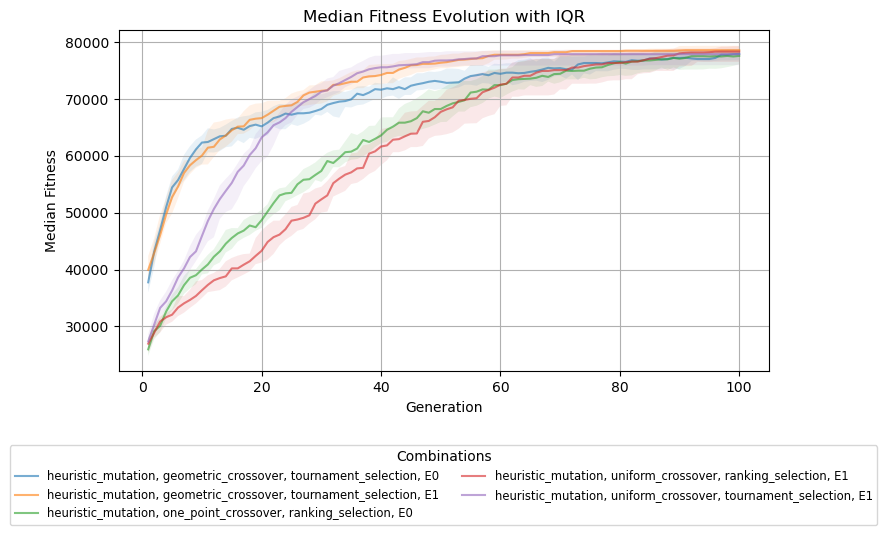

In [ ]:
# Add column combination to fitness_per_run 
if 'combination' not in fitness_per_run.columns:
    fitness_per_run["combination"] = fitness_per_run.apply(
        lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
        axis=1
    )

# Filter fitness_per_run to have only 5 top combinations
fitness_per_run_top5 = fitness_per_run[fitness_per_run["combination"].isin(top_5_names)]

# Plot only top 5
plot_median_fitness_per_gen(fitness_per_run_top5)

**Statistical analysis:**

In [22]:
# Boxplots for top 5 configurations
combs_boxplots_top5(comb_last_gen_fitness_per_run, summary_stats, top_5_names)

In [19]:
# Filter top 5 combinations
comb_last_gen_fitness_per_run_top = comb_last_gen_fitness_per_run[top_5_names].copy()

# Test significance of differences between configurations
test_significant_diffs(comb_last_gen_fitness_per_run_top, 5)

Friedman test statistic: 8.8926, p-value: 0.0638
No statistically significant differences were found between the configurations.


In [331]:
 # Compute summary statistics to analyze stability of performance
summary_stats = combs_summary_stats(comb_last_gen_fitness_per_run_top)

Fitness Summary per Configuration:


,configuration,min_score,q1_score,median_score,q3_score,max_score,iqr_score
0,"heuristic_mutation, geometric_crossover, tournament_selection, E1",74200,77950.0,78600.0,79375.0,80300,1425.0
1,"heuristic_mutation, uniform_crossover, ranking_selection, E1",69100,76550.0,78350.0,79300.0,81400,2750.0
2,"heuristic_mutation, geometric_crossover, tournament_selection, E0",71200,76825.0,77950.0,78775.0,80000,1950.0
3,"heuristic_mutation, uniform_crossover, tournament_selection, E1",73300,75975.0,77900.0,78650.0,80400,2675.0
4,"heuristic_mutation, one_point_crossover, ranking_selection, E0",70900,76125.0,77600.0,78550.0,79800,2425.0


- Heuristic mutation is present in all of the top five configurations.
- Geometric and uniform crossover are both represented 2 times in the top 5.
- Tournment selection is present in 3 out of 5 of the top configurations.
- Elitism with elits=1 appears 3 times in the top configurations.

**Final conclusion:**
Between these, HM_GC_TS_E1 presents the lowest interquartile range and the highest median fitness across runs for the last generation. For these reason we believe it represents the best configuration. Since no statistical significant differences are found between these 3 configurations, we will rely on the remaining methods used.

    1st: shortest interquartile range.

    1st: highest median average fitness in last genaration.



**Selected configuration of first grid search:**
- Population size = 100 (fixed).
- Max generations = 100 (fixed).
- Crossover probability = 0.9 (fixed).
- Mutation probability = 0.1 (fixed).
- Tournment size = 3 (fixed).
- Selection method: Tournment.
- Mutation operator: Heuristic.
- Crossover operator: Geometric.
- Elits = 1.

<a class="anchor" id="gd2">

## 4. Grid search for optimization - tournment size and number of elits

</a>

After selection of the best configuration from the previous grid search, we decided to perform a 2nd grid search to further optimize the hyperparameters. 

**Fixed hyperparameters:**
- Population size = 100.
- Max generations = 100.
- Crossover probability = 0.9.
- Mutation probability = 0.1
- Tournment selection.
- Geometric crossover.
- Heuristic mutation.

**Hyperparameters to test:**
- Tournment size: 2, 3, 5 and 7.
- Number of elits: 1, 3 and 5.

In [ ]:
tourn3 = partial(tournament_selection, tournament_size=3)
tourn5 = partial(tournament_selection, tournament_size=5)
tourn2 = partial(tournament_selection, tournament_size=2)
tourn7 = partial(tournament_selection, tournament_size=7)

tourn3.__name:__ = "tournament_k3"
tourn5.__name__ = "tournament_k5"
tourn2.__name__ = "tournament_k2"
tourn7.__name__ = "tournament_k7"

results2 = grid_search_par(
    relations_mtx=relationships_mtx,
    mutation_functions=[heuristic_mutation], # add best mutation
    crossover_functions=[geometric_crossover], # add best crossover
    selection_functions=[tourn3, tourn5, tourn2, tourn7], # add best selection
    elitism=[1,3,5]
)

In [ ]:
results_table2 = pd.DataFrame(results2).style \
    .format(precision=3) \
    .set_properties(**{"text-align": "center"}) \
    .set_table_styles([{
        "selector": "th",
        "props": [("text-align", "center")]
    }])

results_table2

,mutation,crossover,selection,elitism,last_gen_avg_fitness,solution_highest_fitness,execution_time
0,heuristic_mutation,geometric_crossover,tournament_k5,1,78640.000,"Table 0: [33, 34, 35, 36, 37, 43, 49, 59] Table 1: [31, 32, 38, 39, 40, 41, 42, 44] Table 2: [45, 46, 47, 53, 54, 55, 56, 57] Table 3: [4, 22, 23, 24, 25, 26, 27, 48] Table 4: [50, 51, 52, 58, 60, 61, 62, 63] Table 5: [10, 11, 12, 13, 14, 28, 29, 30] Table 6: [5, 15, 16, 17, 18, 19, 20, 21] Table 7: [0, 1, 2, 3, 6, 7, 8, 9]",22.573


<a class="anchor" id="perfanalysis2">

## 4.1. Performance analysis

</a>


In [ ]:
# Load fitness per run for all combinations
fitness_per_run2 = pd.read_csv("fitness_per_run_2025-05-23_11-27-35.csv")

In [247]:
# Create csv with median 
csv_median_fitness_per_gen(fitness_per_run2, "2025-05-23_11-27-35")

In [248]:
# Load median fitness per generation for all combinations
median_fit_per_gen2 = pd.read_csv("median_fit_per_generation_2025-05-23_11-27-35.csv")

**Performance of tournment sizes and number of elits:**

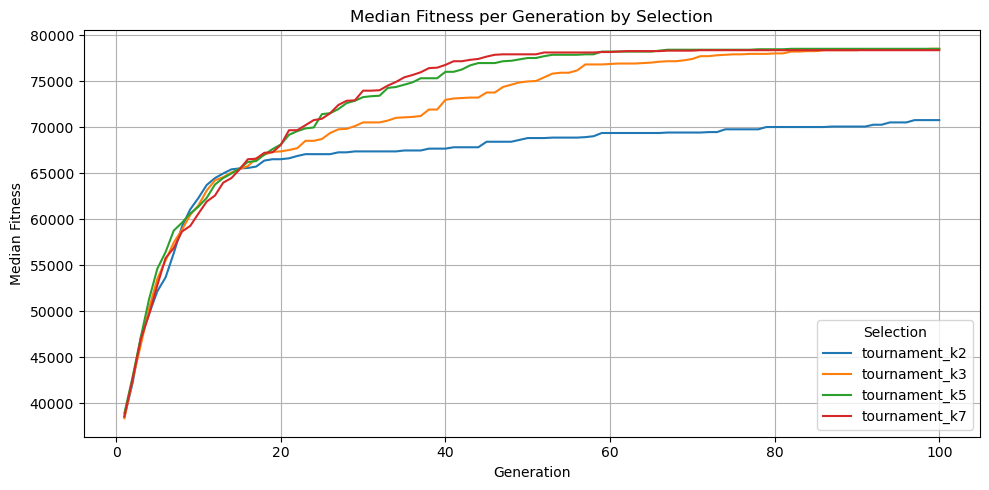

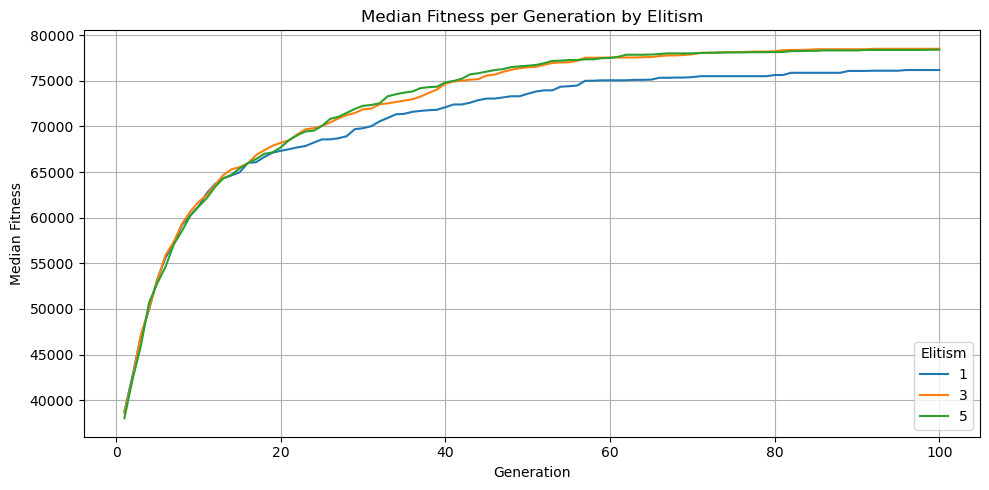

In [310]:
# Plot fitness history for each selection and elitism

parameters = ["selection", "elitism"]

for par in parameters: 
    plot_median_fitness_by_parameter(median_fit_per_gen2, par)

Both number of elits and tournment size present faster convergence and higher performance in the last generation for the highest values.

**Fitness history:**

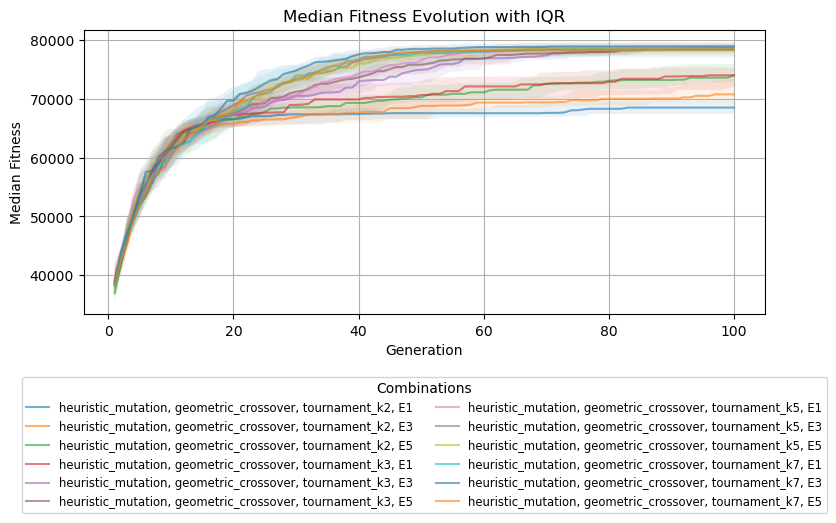

In [258]:
plot_median_fitness_per_gen(fitness_per_run2)

The median performance of k7, E3 has a faster convergence and presents a higher fitness in the last generation than K7, E5.

**Statistical analysis:**
- Friedman test for significant differences.
- Post-hoc Nemenyi to analyze significant differences pair-wise.
- Boxplots and statistics summary - median, quartiles, interquartile distance - to analyze stability of results.

In [260]:
# For each combination get last generation fitness acrosso 30 runs 

last_gen2 = fitness_per_run2[fitness_per_run2["generation"] == 100].copy()

last_gen2["configuration"] = last_gen2.apply(
    lambda row: f"{row['mutation']}, {row['crossover']}, {row['selection']}, E{row['elitism']}",
    axis=1
)

grouped2 = last_gen2.groupby("configuration")["fitness"].apply(list)

comb_last_gen_fitness_per_run2 = pd.DataFrame(grouped2.tolist(), index=grouped2.index).T

Friedman test statistic: 215.3392, p-value: 0.0000
There are statistically significant differences between the configurations.


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0000,0.9990,0.3356,0.2921,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9990,1.0000,0.9120,0.8841,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.3356,0.9120,1.0000,1.0000,0.0000,0.0002,0.0000,0.0000,0.0001,0.0001,0.0000,0.0002
3,0.2921,0.8841,1.0000,1.0000,0.0000,0.0003,0.0000,0.0000,0.0002,0.0002,0.0000,0.0003
4,0.0000,0.0000,0.0000,0.0000,1.0000,0.9761,0.9998,0.9988,0.9845,0.9827,1.0000,0.9761
5,0.0000,0.0000,0.0002,0.0003,0.9761,1.0000,1.0000,1.0000,1.0000,1.0000,0.9891,1.0000
6,0.0000,0.0000,0.0000,0.0000,0.9998,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.0000,0.0000,0.0000,0.0000,0.9988,1.0000,1.0000,1.0000,1.0000,1.0000,0.9997,1.0000
8,0.0000,0.0000,0.0001,0.0002,0.9845,1.0000,1.0000,1.0000,1.0000,1.0000,0.9935,1.0000
9,0.0000,0.0000,0.0001,0.0002,0.9827,1.0000,1.0000,1.0000,1.0000,1.0000,0.9926,1.0000


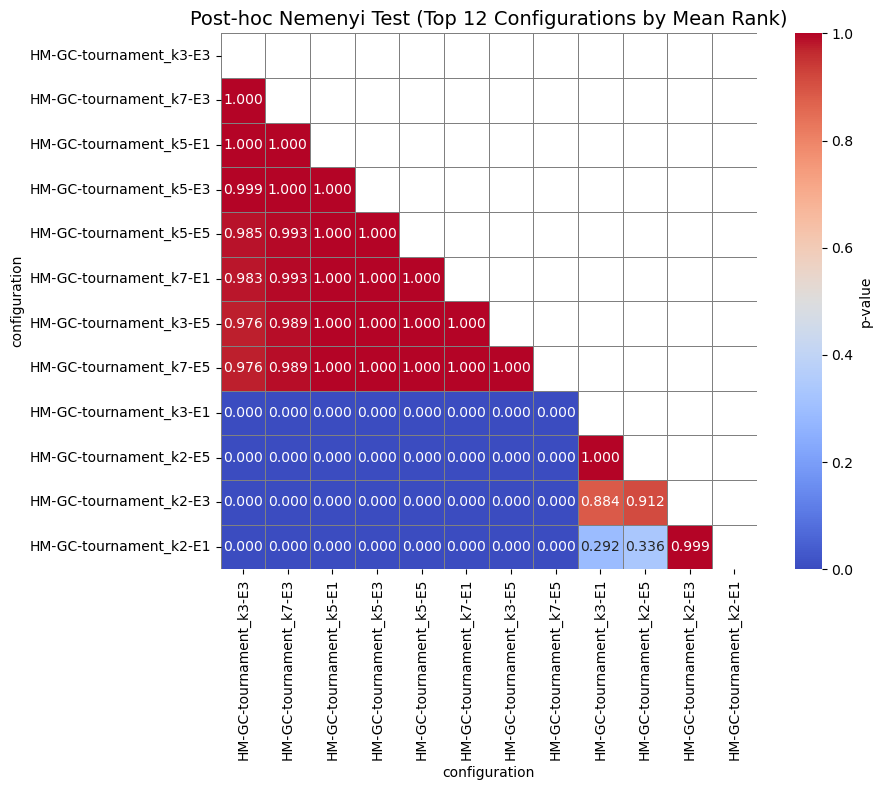

In [261]:
test_significant_diffs(comb_last_gen_fitness_per_run2, 12)

In [262]:
combs_boxplots_per_selection(comb_last_gen_fitness_per_run2)

In [268]:
pd.set_option('display.max_colwidth', None)

summary_stats2 = combs_summary_stats(comb_last_gen_fitness_per_run2)

Fitness Summary per Configuration:


,configuration,min_score,q1_score,median_score,q3_score,max_score,iqr_score
10,"heuristic_mutation, geometric_crossover, tournament_k7, E3",76700,78275.0,78900.0,79575.0,80000,1300.0
4,"heuristic_mutation, geometric_crossover, tournament_k3, E3",76400,78500.0,78600.0,79100.0,80100,600.0
8,"heuristic_mutation, geometric_crossover, tournament_k5, E5",74500,77725.0,78600.0,78975.0,80200,1250.0
5,"heuristic_mutation, geometric_crossover, tournament_k3, E5",74500,77900.0,78500.0,78675.0,80000,775.0
6,"heuristic_mutation, geometric_crossover, tournament_k5, E1",74900,78225.0,78500.0,79250.0,79900,1025.0
7,"heuristic_mutation, geometric_crossover, tournament_k5, E3",74500,78125.0,78400.0,79275.0,80900,1150.0
9,"heuristic_mutation, geometric_crossover, tournament_k7, E1",73500,77025.0,78350.0,79150.0,81300,2125.0
11,"heuristic_mutation, geometric_crossover, tournament_k7, E5",74400,77375.0,78300.0,79475.0,80200,2100.0
2,"heuristic_mutation, geometric_crossover, tournament_k2, E5",71800,72850.0,74000.0,75925.0,78400,3075.0
3,"heuristic_mutation, geometric_crossover, tournament_k3, E1",68100,72125.0,74000.0,75325.0,78800,3200.0


K3, E3 presents the 2nd highest median fitness in the last genaration and the shortest interquartile range, which indicates stability while still reaching a top performance.

**Conclusion:** We believe E3, K3 is the best configuration, standing out for the stablity of results. Since no statistical significant differences are found between the best configurations of the applied methods, we will rely on the remaining methods used.

    1st: shortest interquartile range.

    2nd: highest median average fitness in last genaration.

**Final configuration:**
- Population size = 100.
- Max generations = 100.
- Crossover probability = 0.9.
- Mutation probability = 0.1.
- Selection method: Tournment.
- Mutation operator: Heuristic.
- Crossover operator: Geomatric.
- Tournment size = 3.
- Elits = 3.